#  Sound Effects Tagging

## Goal
This task is to annotate or tag a sound with descriptive (semantic) keywords.  This kind of content-based tagging system could be useful to musicians and sound engineers who want to automatically organize their sound library, or search for sounds by keyword.


## Methodology
Semantic annotation is a multi-label classification problem, where each label corresponds to one sound tag and is a binary classification problem. The labels can co-occur (multiple labels can be assigned to the same sound), which makes it different from multi-class classification (where only one label can be assigned).  Sound is a temporal process, so the important thing is how to define the _feature space_ for representing the sound, before learning the binary classifiers. You are free to choose appropriate methods (e.g., feature extraction method, dimensionality reduction, and clustering methods) to help define a suitable feature space for sound annotation.


## Evaluation of Tagging

For evaluation, you will predict the presence/absence of tags for each test sound. The evaluation metric is "Mean column-wise AUC".  AUC is the area under the ROC curve, which plots FPR vs TPR.  "Mean column-wise" computes the average of the AUCs for the tags.  To compute AUC, you will need to predict the score of each label (e.g., decision function value, probability, etc.) rather than the label.


<hr>

In [42]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
random.seed(100)
import csv
from scipy import io
import pickle
from IPython.display import Audio, display

In [43]:
def showAudio(info):
    display(Audio(info['previews']['preview-lq-mp3']))

def load_pickle(fname):
    f = open(fname, 'rb')
    out = pickle.load(f)
    f.close()
    return out

# Load the Data
The training and test data are stored in various pickle files.
The below code will load the data.

In [44]:
train_tags  = load_pickle('train_tags.pickle3')
train_mfccs = load_pickle('train_mfccs.pickle3')
train_info  = load_pickle('train_info.pickle3')

test_mfccs = load_pickle('test_mfccs.pickle3')
test_info  = load_pickle('test_info.pickle3')

Here are the things in the dataset:

- `train_info` - info about each sound in the training set (contains a link to the sound).
- `train_mfccs` - the MFCC features for each sound in the training set.  MFCCs are [Mel-frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum), which are a type of spectral feature vector for audio.
- `train_tags` - the descriptive tags for each sound in the training set. Tags have already been stemmed.
- `test_info` - info about each sound in the test set.
- `test_mfccs` - the MFCC features for each sound in the test.

Here is the first sound in the training set, as well as the tags.

In [45]:
showAudio(train_info[0])
print(train_tags[0])

['metal']


and here are the MFCCs for the first sound in the training set.  The MFCC vectors are 13-dimensions each, and they are extracted using a sliding window over the sound.

(345, 13)


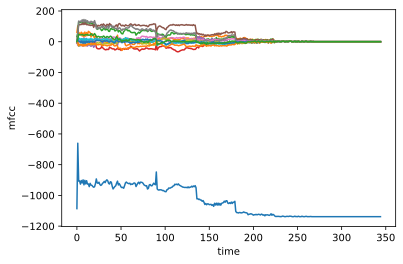

In [46]:
print(train_mfccs[0].shape)
plt.plot(train_mfccs[0]);
plt.xlabel('time')
plt.ylabel('mfcc');

## Data Pre-processing - Delta MFCCs

The first thing you might notice is that the MFCC vectors are time-series.  One trick to include time-series information into a vector representation is to append the difference between two consecutive feature vectors.  This way, we can include some relationship between two time steps in the representation.

In [47]:
# compute delta MFCCs
def compute_delta_mfccs(mfccs):
    dmfccs = []
    for m in mfccs:
        tmp = m[1:] - m[0:-1]
        dm = hstack((m[0:-1], tmp))
        dmfccs.append(dm)
    return dmfccs

In [48]:
train_dmfccs = compute_delta_mfccs(train_mfccs)
test_dmfccs  = compute_delta_mfccs(test_mfccs)

In [49]:
print(train_dmfccs[0][0])

[-1.08599561e+03  6.16124954e+01  3.26212196e+01  4.88774490e+00
 -9.12226868e+00 -8.47605133e+00 -7.11513519e-01  4.72403717e+00
  3.38615799e+00 -1.22250366e+00 -2.96123886e+00 -7.83477783e-01
  1.45116425e+00  4.25331665e+02  4.10426712e+01  2.63916092e+01
  2.21846256e+01  1.22690163e+01  5.83558960e+01 -2.38054867e+01
  3.96332779e+01 -1.63995991e+01  1.71343832e+01  1.39941864e+01
 -2.17901421e+00  1.58920860e+01]


## Data Pre-processing - bag-of-words

The next problem you might notice is that the number of MFCCs is different for each sound, since sound can have different lengths.  Hence, before using our machine learning algorithms, we need to encode the MFCCs into a vector.

One solution is to use a "bag-of-audio-words" representation, which is analogous to the bag-of-words representation for text.
Here, we build a vocabulary of "audio-words" and map each MFCC to one of the words.  Then we can represent each sound as a histogram of counts.

We will use the k-means clustering algorithm to build the codebook of audio words.  .

In [50]:
# put dmfccs from all training data together
all_dmfccs = vstack(train_dmfccs)
print(all_dmfccs.shape)

(391816, 26)


In [51]:
# run k-means to build codebook
km = cluster.KMeans(n_clusters=100, random_state=4487)
km.fit(all_dmfccs[0::10])  # subsample by 10 to make it faster
km.cluster_centers_

array([[-6.79226424e+02,  3.22734947e+00,  2.43158406e+01, ...,
        -4.31294207e-01, -4.78375380e-01, -5.22028559e-01],
       [-1.06327080e+03,  9.71610538e+01,  7.82367331e+01, ...,
         4.17804862e-01,  3.10334627e-01,  1.57418995e-01],
       [-8.99103765e+02,  2.11683392e+02,  5.03105377e+01, ...,
         4.14658095e-01,  1.02921782e-01, -1.80325519e-01],
       ...,
       [-6.04597586e+02,  6.10640047e+01, -2.92856969e+01, ...,
         2.60369086e-02,  4.82926020e-01,  2.77534274e-02],
       [-6.16840241e+02,  1.07736226e+02,  6.68782176e+00, ...,
        -5.60695712e-01, -1.04826415e+00, -1.15314174e+00],
       [-7.83613275e+02,  2.58168823e+02, -1.55174285e+01, ...,
        -4.23635998e-01,  2.38463489e-01,  2.26068241e-01]])

Now transform the data into BOW.

In [52]:
def bow_transform(model, mfccs):
    numwords = model.cluster_centers_.shape[0]
    bows = zeros((len(mfccs), numwords))
    for i in range(len(mfccs)):
        w = model.predict(mfccs[i])
        bw = bincount(w, minlength=numwords)
        bows[i,:] = bw
    return bows

In [53]:
train_bow = bow_transform(km, train_dmfccs)
test_bow  = bow_transform(km, test_dmfccs)

Apply TF-IDF to the count vectors.

In [54]:
# convert to TF
tf_trans = feature_extraction.text.TfidfTransformer(use_idf=True, norm='l1')
train_Xtf = tf_trans.fit_transform(train_bow)
test_Xtf  = tf_trans.transform(test_bow)

# Tag pre-processing

Next, we extract all the tags from the data, and get a unique list of tags.

In [55]:
tagnames, tagnames_counts = unique(concatenate(train_tags), return_counts=True)
for a,b in zip(tagnames, tagnames_counts):
    print("{}: {}".format(a, b))

acoust: 100
analog: 100
bass: 160
beat: 128
drum: 371
effect: 141
electron: 194
field: 110
glitch: 110
guitar: 130
hit: 110
loop: 237
machin: 100
metal: 117
nois: 199
percuss: 285
record: 192
space: 125
synth: 220
synthes: 136
vocal: 120
voic: 167


In [56]:
# convert list of tags into binary class labels
def tags2class(tags, tagnames):
    b = zeros(shape=(len(tags), len(tagnames)))
    for i,t in enumerate(tags):
        for j,n in enumerate(tagnames):
            if n in t:
                b[i,j] = 1
    return b

Now we convert the list of tags for each sound into binary attributes.

In [57]:
# train_classes[i,j] = absence/presence of the j-th tag in the i-th sound
train_classes = tags2class(train_tags, tagnames)

In [58]:
# double check we did this correctly...
# it should be the same as the tag counts above
sum(train_classes,axis=0)

array([100., 100., 160., 128., 371., 141., 194., 110., 110., 130., 110.,
       237., 100., 117., 199., 285., 192., 125., 220., 136., 120., 167.])

In [59]:
# convert binary class vector into a list of tags
def class2tags(classes, tagnames):
    tags = []
    for n in range(classes.shape[0]):
        tmp = []
        for i in range(classes.shape[1]):
            if classes[n,i]:
                tmp.append(tagnames[i])
        tags.append(" ".join(tmp))
    return tags

## CODE and DOCUMENTATION

### 1. Machine Learning + Handcrafted Feature

* feature: TF, TFIDF
* model: linearSVM, rbfSVM, LR
* dimension reduction: LSA, NFM, rbf Kernel PCA

In [60]:
import logging
from tqdm import tqdm

from collections import OrderedDict
import pandas as pd
import numpy as np
import itertools
import os

import warnings
warnings.filterwarnings('ignore')

LOG_FORMAT = "%(asctime)s - %(levelname)s - %(message)s"
logging.basicConfig(level=logging.INFO, format=LOG_FORMAT)

#### step 0: define util functions

In [61]:
# plot an ROC curve using class labels and class scores
def get_roc(tagnames, Yclasses, Yscores, plot=True):
    fprall = []
    tprall = []
    aucall = []
    for i in range(len(tagnames)):
        fpr, tpr, thresholds = metrics.roc_curve(Yclasses[:,i], Yscores[:,i])
        plt.plot(fpr, tpr, lw=0.5, alpha=0.5)
        auc = metrics.auc(fpr, tpr)
        fprall.append(fpr)
        tprall.append(tpr)
        aucall.append(auc)

    # Then interpolate all ROC curves at this points
    all_fpr = unique(concatenate(fprall))
    mean_tpr = zeros_like(all_fpr)
    for i in range(len(tagnames)):
        mean_tpr += interp(all_fpr, fprall[i], tprall[i])

    # Finally average it and compute AUC
    mean_tpr /= len(tagnames)

    # auc of the average ROC curve
    auc = metrics.auc(all_fpr, mean_tpr)

    # average AUC
    mc_auc = mean(aucall)
    
    if plot:
        plt.plot(all_fpr, mean_tpr, 'k-', lw=2)
        plt.title('MCAUC={:.4f}, AUC={:.4f}'.format(mc_auc, auc))
        plt.grid(True)
        plt.show()
        
    return mc_auc

In [62]:
def train(CLS, train_feat_mat, reduction=None, **model_kwarg):
    '''
    given classifier class, training feature matrix, dim reductor,
    return mc_auc score
    '''
    global train_mfccs, train_classes, tagnames, get_roc
    
    if reduction is not None:
        train_feat_mat = reduction.fit_transform(train_feat_mat)
    
    # train model
    tagmodels = {}
    logging.info('training models for {:d} tags'.format(len(tagnames)))
    i = 0
    for t in tqdm(tagnames, disable=False):
        myY = train_classes[:,i].ravel()
        classifier = CLS(**model_kwarg)
        classifier.fit(train_feat_mat, myY)
        tagmodels[t] = classifier
        i += 1
    
    # get train_acc
    train_predscore = zeros(shape=(len(train_mfccs), len(tagnames)))
    logging.info('prediction for {:d} tags'.format(len(tagnames)))
    i = 0
    for t in tqdm(tagnames):
#         print('predicting {} - {}'.format(i, t))
        tmp = tagmodels[t].decision_function(train_feat_mat)
        train_predscore[:,i] = tmp
        i += 1
    
    # plot roc
    mc_auc = get_roc(tagnames, train_classes, train_predscore)
    
    return mc_auc, tagmodels, reduction

In [63]:
def get_test_pred_score(tagmodels, test_feature, dim_reductor=None):
    global test_mfccs, tagnames
    
    if dim_reductor is not None:
        test_feature = dim_reductor.transform(test_feature)
    
    test_predscore = zeros(shape=(len(test_mfccs), len(tagnames)))
    i = 0
    for t in tqdm(tagnames):
#         print('predicting {} - {}'.format(i, t))
        tmp = tagmodels[t].decision_function(test_feature)
        test_predscore[:,i] = tmp
        i += 1
    
    return test_predscore

In [64]:
import csv

def write_csv_kaggle_tags(fname, tagnames, Yscores):
    # header
    tmp = [['Id']]
    for t in tagnames:
        tmp[0].append(t)    
    
    # add ID numbers for each Y, and usage if necessary
    for i in range(len(Yscores)):
        tmp2 = [(i+1)]
        for t in range(len(tagnames)):
            tmp2.append(Yscores[i,t])
        
        tmp.append(tmp2)
        
    # write CSV file
    f = open(fname, 'w')
    writer = csv.writer(f)
    writer.writerows(tmp)
    f.close()

#### step 1: try different feature, classifier, dimension reduction combinations

* feature: TF, TFIDF
* model: linearSVM, rbfSVM, LR
* dimension reduction: LSA, NFM, rbf Kernel PCA


In [65]:
print(train_Xtf.shape)

(1788, 100)


In [66]:
N_JOBS=10

model_dict = OrderedDict()
feat_dict = OrderedDict()
feat_dict_test = OrderedDict()
reductor_dict = OrderedDict()

## different models 
model_dict['linearSVM'] = (model_selection.GridSearchCV,
                           {'estimator': svm.LinearSVC(class_weight='balanced'),
                            'param_grid': {'C': logspace(-3,3,13)},
                            'cv': 5,
                            'n_jobs': N_JOBS}
                          )

model_dict['rbfSVM'] = (model_selection.GridSearchCV,
                           {'estimator': svm.SVC(kernel='rbf',
                                                 class_weight='balanced'),
                            'param_grid': {'C': logspace(-3,3,13)},
#                                            'gamma': logspace(-4, 4, 20)},
                            'cv': 5,
                            'n_jobs': N_JOBS}
                          )

model_dict['LR'] = (linear_model.LogisticRegressionCV,
                    {'Cs': logspace(-4,4,20),
                     'cv': 5,
                     'class_weight': 'balanced',
                     'solver': 'liblinear'}
                   )

feat_dict['TF'] = train_Xtf
feat_dict['BOW'] = train_bow

feat_dict_test['TF'] = test_Xtf
feat_dict_test['BOW'] = test_bow

# different dimension reduction methods
reductor_dict['None'] = None

reductor_dict['LSA10'] = decomposition.TruncatedSVD(n_components=10,
                                                    random_state=4487)
reductor_dict['LSA30'] = decomposition.TruncatedSVD(n_components=30,
                                                    random_state=4487)
# reductor_dict['LPCA10'] = decomposition.PCA(n_components=10)
# reductor_dict['LPCA30'] = decomposition.PCA(n_components=30)
reductor_dict['rbfPCA10'] = decomposition.KernelPCA(n_components=10, kernel='rbf')
reductor_dict['rbfPCA30'] = decomposition.KernelPCA(n_components=30, kernel='rbf')


reductor_dict['NMF10'] = decomposition.NMF(n_components=10)
reductor_dict['NMF30'] = decomposition.NMF(n_components=30)



In [ ]:
score_dict = OrderedDict()
best_score = 0.
best_comb = None
for f_name, feat_mat in feat_dict.items(): 
    for m_name, (CLS, param) in model_dict.items():
        for r_name, reductor in reductor_dict.items():
            logging.info('feature: {:s}, model: {:s}, reduction: {:s}'.format(f_name,
                                                                              m_name,
                                                                              r_name))
            score, _, _ = train(CLS=CLS,
                              train_feat_mat=feat_mat,
                              reduction=reductor,
                              **param)
            logging.info('current mc_auc score: {:.4f}'.format(score))
            # record score
            key = (f_name, m_name, r_name)
            score_dict[key] = score
            if score > best_score:
                best_score = score
                best_comb = key

#### step 2: get report and generate submission using best pipeline discovered

In [68]:
report_df = pd.DataFrame(columns=feat_dict.keys(),
                         index=list(itertools.product(model_dict.keys(),
                                                      reductor_dict.keys())))
                                   
# report_df
for (f_name, m_name, r_name), score in score_dict.items():
#     report_df[(m_name, r_name)][f_name] = score
    report_df[f_name][(m_name, r_name)] = score

In [69]:
report_df.style.highlight_max(axis=1)

,TF,BOW
"('linearSVM', 'None')",0.863211,0.731391
"('linearSVM', 'LSA10')",0.701815,0.600186
"('linearSVM', 'LSA30')",0.770009,0.619348
"('linearSVM', 'rbfPCA10')",0.713599,0.617031
"('linearSVM', 'rbfPCA30')",0.78032,0.677723
"('linearSVM', 'NMF10')",0.710665,0.626279
"('linearSVM', 'NMF30')",0.779869,0.694917
"('rbfSVM', 'None')",0.924284,0.905865
"('rbfSVM', 'LSA10')",0.899515,0.760101
"('rbfSVM', 'LSA30')",0.913732,0.830931


In [70]:
print(best_comb, best_score)
# best_comb = ('TF', 'rbfSVM', 'None')

('TF', 'rbfSVM', 'None') 0.9242838215765912


2020-03-31 11:07:06,581 - INFO - training models for 22 tags
100%|██████████| 22/22 [00:43<00:00,  1.98s/it]
2020-03-31 11:07:50,204 - INFO - prediction for 22 tags
100%|██████████| 22/22 [00:03<00:00,  5.79it/s]


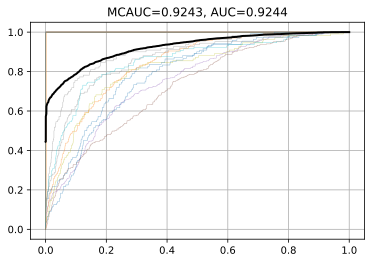

In [71]:
best_score, tagmodels, reductor = train(CLS=model_dict[best_comb[1]][0],
                                 train_feat_mat=feat_dict[best_comb[0]],
                                 reduction=reductor_dict[best_comb[2]],
                                 **model_dict[best_comb[1]][1])

Now apply the best classifiers to the test set to predict the score for each tag.

In [72]:
test_pred_score =  get_test_pred_score(tagmodels=tagmodels,
                    test_feature=feat_dict_test[best_comb[0]],
                    dim_reductor=reductor)

100%|██████████| 22/22 [00:00<00:00, 39.09it/s]


In [74]:
save_name = '{:s}_{:s}_{:s}_acc_{:.4f}.csv'.format(best_comb[0],
                                                   best_comb[1],
                                                   best_comb[2],
                                                   best_score)
save_path  = os.path.join('submissions', save_name)
write_csv_kaggle_tags(save_path, tagnames, test_pred_score)

### 2. Deep Learning

* RNN + MFCC sequence
* 1D CNN + MFCC sequence **(pending)**
* 2D CNN + MFCC map **(pending)**
* 2D CNN + MelSpectrogram **(pending)**
* RNN + raw audio **(pending)**
* 1D CNN + raw audio **(pending)**


BOW feature lost temporal information. CNN or RNN can take temporal information into consideration.

#### 2.1 RNN + MFCC sequence

In [75]:
num_classes = len(tagnames)
num_train = len(train_mfccs)
num_test = len(test_mfccs)
pos_cnt = train_classes.sum(0)

print(f'num_classes: {num_classes}')
print(f'number of training samples: {num_train}')
print(f'number of testing samples: {num_test}')
print(f'number of positives in each class:\n {pos_cnt}')


print(f'train_mfccs[0].shape: {train_mfccs[0].shape}')
print(f'train_classes.shape: {train_classes.shape}')

num_classes: 22
number of training samples: 1788
number of testing samples: 262
number of positives in each class:
 [100. 100. 160. 128. 371. 141. 194. 110. 110. 130. 110. 237. 100. 117.
 199. 285. 192. 125. 220. 136. 120. 167.]
train_mfccs[0].shape: (345, 13)
train_classes.shape: (1788, 22)


##### import packages

In [76]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import DataLoader, random_split
import numpy as np
import logging
import os

# dataset
from extra.dataset import MFCCDataset, MyPadCollate

# train utils
from extra.train_utils import train, evaluate, AUROC, \
                              grid_search, load_model


# https://pytorch.org/docs/stable/notes/randomness.html
SEED = 10086
torch.manual_seed(SEED)
np.random.seed(SEED)
# https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936/3
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

##### prepare dataset and data loader

In [77]:
mfcc_dataset = MFCCDataset(train_mfccs, train_classes)
allloader = DataLoader(mfcc_dataset,
                             batch_size=64,
                             collate_fn=MyPadCollate(batch_first=True))

In [78]:
train_val_split_ratio = 0.9
train_num = int(train_val_split_ratio * len(mfcc_dataset))
valid_num = len(mfcc_dataset) - train_num
mfcc_train, mfcc_valid = random_split(mfcc_dataset,
                                      (train_num, valid_num))

print(len(mfcc_train))
print(len(mfcc_valid))

1609
179


In [79]:
trainloader = DataLoader(mfcc_train,
                         batch_size=64,
                         shuffle=True,
                         collate_fn=MyPadCollate(batch_first=True))

validloader = DataLoader(mfcc_valid,
                         batch_size=64,
                         shuffle=True,
                         collate_fn=MyPadCollate(batch_first=True))

##### we are ready to do training

In [ ]:
paramgrid = {
    'model.hidden_dim': [256, 128, 64],
    'model.dropout': [0.3, 0.2],
    'model.n_layers': [2, 3] ,
    'loss.pos_weight': [None, pos_cnt/num_train],
    'optim.lr': [1e-3]
}


best_save_path, best_score = grid_search('gru',
                                         param_grid=paramgrid,
                                         trainloader=trainloader,
                                         validloader=validloader) 

##### confirm score and save path 

In [ ]:
# confirm score on training set and validation set
print(best_save_path)
model = load_model(best_save_path)

allloader = DataLoader(mfcc_dataset,
                       batch_size=128,
                       collate_fn=MyPadCollate(True)
                      )

pred, (mc_auc, auc) = evaluate(model, allloader, AUROC(len(tagnames)))
print(mc_auc, auc)

pred, (mc_auc, auc) = evaluate(model, validloader,
                               AUROC(len(tagnames)))
print(mc_auc, auc)

##### evaluate on test data

In [ ]:
n = len(tagnames)
pseudo_test_label = np.random.randint(2, size=(len(test_mfccs), n))
test_dataset = MFCCDataset(test_mfccs, pseudo_test_label)

test_loader = DataLoader(test_dataset,
                         shuffle=False,
                         batch_size=128,
                         collate_fn=MyPadCollate(True))

test_preds, _ = evaluate(model, test_loader,
                         AUROC(len(tagnames)))

##### write submission

In [ ]:
save_name = os.path.basename(best_save_path)[:-2]+'csv'
write_csv_kaggle_tags(save_name, tagnames, test_preds)

#### 2.4 2D CNN + MelSpectrogram (Unfinished)

##### extract feature from raw audio

In [ ]:
import urllib.request
import os
from tqdm import tqdm

In [ ]:
train_info[0]

In [ ]:
mp3_dir = 'mp3'
train_dir = os.path.join(mp3_dir, 'train')
test_dir = os.path.join(mp3_dir, 'test')
os.makedirs(mp3_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
def download_mp3(url, save_path):
    with urllib.request.urlopen(url) as response:
        data = response.read()
    with open(save_path, 'wb') as f:
        f.write(data)

In [ ]:
logging.info('Download training mp3 data...')
i = 0
for info in tqdm(train_info):
    fname = f'train_{i:04d}.mp3'
    save_path = os.path.join(train_dir, fname)
    url = train_info[i]['previews']['preview-hq-mp3']
    download_mp3(url, save_path)
    i += 1

In [ ]:
import pandas as pd
map_csv = os.path.join(mp3_dir, 'train.csv')

df = pd.DataFrame(train_classes, columns=tagnames)
df.insert(0, column='file_name', value=[f'train_{i:04d}.mp3' for i in range(len(train_mfccs))])

df.to_csv(map_csv, index=False)

In [ ]:
logging.info('Download testing mp3 data...')
i = 0
for info in tqdm(test_info):
    save_path = os.path.join(test_dir, f'test_{i:04d}.mp3')
    url = test_info[i]['previews']['preview-hq-mp3']
    download_mp3(url, save_path)
    i += 1

### 3. Observations 

#### 3.1 It's poossible to get more information (feature) from Internet

* both train_info and test_info have a field 'analysis_frames'. It provides a link to access more information of data from Internet

In [82]:
print(train_info[1])

{'tags': ['emotive', 'juicy', 'synth'], 'id': 714, 'analysis_frames': 'http://www.freesound.org/data/analysis/0/714_19_frames.json', 'previews': {'preview-lq-ogg': 'http://www.freesound.org/data/previews/0/714_19-lq.ogg', 'preview-hq-ogg': 'http://www.freesound.org/data/previews/0/714_19-hq.ogg', 'preview-hq-mp3': 'http://www.freesound.org/data/previews/0/714_19-hq.mp3', 'preview-lq-mp3': 'http://www.freesound.org/data/previews/0/714_19-lq.mp3'}}


In [83]:
print(test_info[1])

{'id': 52681, 'analysis_frames': 'http://www.freesound.org/data/analysis/52/52681_164285_frames.json', 'previews': {'preview-lq-ogg': 'http://www.freesound.org/data/previews/52/52681_164285-lq.ogg', 'preview-hq-ogg': 'http://www.freesound.org/data/previews/52/52681_164285-hq.ogg', 'preview-hq-mp3': 'http://www.freesound.org/data/previews/52/52681_164285-hq.mp3', 'preview-lq-mp3': 'http://www.freesound.org/data/previews/52/52681_164285-lq.mp3'}}


In [84]:
import urllib.request, json 
def read_more(info_dict):
    with urllib.request.urlopen(info_dict['analysis_frames']) as url:
        data = json.loads(url.read().decode())
    return data

In [85]:
test_detail_info = read_more(test_info[1])

In [86]:
np.array(test_detail_info['lowlevel']["spectral_centroid"])

array([1346.14501953, 1392.5748291 , 1279.37487793, 1039.67480469,
        831.54864502, 1229.74975586, 1009.97491455, 1231.41687012,
       1220.01391602, 1231.22094727, 1338.33361816, 1304.45983887,
       1056.7677002 , 1137.4642334 , 1280.59362793, 1221.48059082,
       1097.00927734, 1617.91796875, 1400.18615723, 1551.68041992,
       1508.10852051, 1469.88476562, 1438.80358887, 1365.18334961,
       1314.81335449, 1212.3458252 , 1143.41821289, 1299.94543457,
       1390.5604248 , 1390.79040527, 1269.01403809,  875.91992188,
       1231.24182129, 1249.98144531, 1217.92626953, 1251.62597656,
       1276.83483887, 1221.30517578, 1205.90112305, 2599.19873047,
       3339.52197266, 3179.90136719, 3407.03076172, 1943.90209961,
       1583.34228516, 1234.93408203, 1223.65917969, 1041.8963623 ,
       1039.31152344, 1001.16418457,  971.46044922, 1049.50500488,
        697.49786377, 1834.7232666 , 1897.14477539, 1249.56066895,
       1326.47119141, 1226.38415527, 1242.0670166 , 1285.07971

#### 3.2 other possible solutions

* **1D CNN + MFCC sequence**
* **2D CNN + MFCC map**: regard (seq_len, 13) MFCC tensor as a single channel image
* **2D CNN + MelSpectrogram**: similar to the last solution, but using spectrogram 
* **RNN + raw audio**: natural and brute-force way. One may consider how to downsample the audio properly
* **1D CNN + raw audio**

### 4. Reference

* [lRomul/argus-freesound - github](https://github.com/lRomul/argus-freesound)

* [Freesound Audio Tagging 2019 - Kaggle](https://www.kaggle.com/c/freesound-audio-tagging-2019)

* [sktorch](https://github.com/skorch-dev/skorch): $pytorch \times sklearn$ 

* [torchaudio](https://pytorch.org/audio/)